In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from torch.autograd import Variable
import warnings
warnings.filterwarnings('ignore')
np.random.seed(0)

# Data Loading & Preprocessing:

    1. Loading the dataset and Transform into Tensors:

In [2]:
from torchvision import datasets, transforms
dataset_path=datasets.ImageFolder(root='fruits360/Training/', transform=transforms.Compose([transforms.ToTensor()]))

    2. Spliting the dataset Into Train and Test:
    
        Spliting the Dataset into 80% training and 20% testing dataset, and shuffling the dataset to distribute the train 
        and test into random examples 
        

In [3]:
from torch.utils.data.sampler import SubsetRandomSampler

split = int(0.8 * len(dataset_path))
index_list = list(range(len(dataset_path)))
np.random.shuffle(index_list)
train_idx, test_idx = index_list[:split], index_list[split:] ## Traing and testing indexes.


## create sampler objects using SubsetRandomSampler
tr_sampler = SubsetRandomSampler(train_idx)
test_sampler = SubsetRandomSampler(test_idx)
## create iterator objects for train and test datasets
train_loader = torch.utils.data.DataLoader(dataset_path, batch_size=256, sampler=tr_sampler)
test_loader = torch.utils.data.DataLoader(dataset_path, batch_size=256, sampler=test_sampler)

print ("Total Number of Examples: ",len(dataset_path))
print ("Number of training Examples: ",len(tr_sampler))
print ("Number of testing Examples: ",len(test_sampler))

Total Number of Examples:  8147
Number of training Examples:  6517
Number of testing Examples:  1630


In [4]:
Classes_num=len(train_loader.dataset.classes)
print ('Number of Classes',Classes_num)
print('Classes Name: ', train_loader.dataset.classes)

Number of Classes 15
Classes Name:  ['Rambutan', 'Raspberry', 'Redcurrant', 'Salak', 'Strawberry', 'Strawberry Wedge', 'Tamarillo', 'Tangelo', 'Tomato 1', 'Tomato 2', 'Tomato 3', 'Tomato 4', 'Tomato Cherry Red', 'Tomato Maroon', 'Walnut']


Example: 


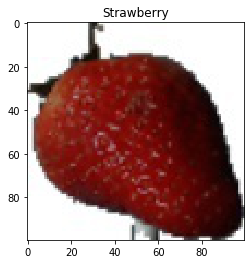

In [5]:
print ('Example: ')
i1, l1 = next(iter(train_loader))
plt.title(train_loader.dataset.classes[l1[0]])
plt.imshow(np.array(i1[0].permute(1, 2, 0)));

# Convolutional Neural Network

The network has the following layout,

    Input > Conv_Layer (ReLU) > MaxPool > Conv_Layer (ReLU) > MaxPool > Conv_Layer (ReLU) > MaxPool > FC (ReLU) > FC (ReLU) > FC (SoftMax) > 15 outputs


        where:
        Conv_Layer is a convolutional layer, ReLU is the activation function, MaxPool is a pooling layer, FC is a fully
        connected layer and SoftMax is the activation function of the output layer.

## Layer Dimensions

Below formula shown to check the size of layer by given parameters.
![Conv layer formula for output size calculation](conv_layer_formula.png)


### Input Size
    
    The images are 3x100x100, i.e., 3 channels (red, green, blue) each of size 100x100 pixels.



### First Convolutional Layer
    
    The first convolutional layer expects 3 input channels and will convolve 6 filters each of size 3x9x9. Since padding
    is set to 0 and stride is set to 1, the output size is 6x92x92, because 
    
                                                        (100−9)+1=92.
    


### First Max-Pooling Layer
    
    The first down-sampling layer uses max pooling with a 2x2 kernel and stride set to 2. This effectively drops the size 
    from 6x92x92 to 6x46x46.



### Second Convolutional Layer
    
    The second convolutional layers expects 6 input channels and will convolve 8 filters each of size 6x7x7. Since 
    padding is set to 0 and stride is set to 1, the output size is 8x40x40, because 
    
                                                        (46−7)+1=40.



### Second Max-Pooling Layer
    
    The second down-sampling layer uses max pooling with a 2x2 kernel and stride set to 2. This effectively drops the size 
    from 8x40x40 to 8x20x20.



### Third Convolutional Layer
    
    The second convolutional layers expects 8 input channels and will convolve 16 filters each of size 8x5x5. Since 
    padding is set to 0 and stride is set to 1, the output size is 16x16x16, because 
    
                                                        (20−5)+1=16.



### Third Max-Pooling Layer
    
    The second down-sampling layer uses max pooling with a 2x2 kernel and stride set to 2. This effectively drops the size 
    from 16x16x16 to 16x8x8.
    


### First Fully-Connected Layer
    
    The output from the final max pooling layer needs to be flattened so that we can connect it to a fully connected layer. 
    This is achieved using the torch.Tensor.view method. By specifying -1 the method will automatically infer the number of 
    rows required. This is done to handle the mini-batch size of data.

    The fully-connected layer uses ReLU for activation and has 1024 nodes.
    


### Second Fully-Connected Layer

    The output from the first fully-connected layer is connected to another fully connected layer with 300 nodes, using 
    ReLU as an activation function.



### Output Layer
    
    The last fully-connected layer uses softmax and is made up of ten nodes, one for each category in Fruit Dataset. So 
    total number of 15 nodes in the output layer.
    
    

![Network Architecture](cnn_general.JPG)

In [5]:
import torch.nn.functional as F
import torch.nn as nn

class Model(nn.Module):

    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=6, kernel_size=9, stride=1, padding=0)
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=8, kernel_size=7, stride=1, padding=0)
        
        self.conv3 = nn.Conv2d(in_channels=8, out_channels=16, kernel_size=5, stride=1, padding=0)
        
        self.fc1 = nn.Linear(8*8*16, 300)
        self.fc2 = nn.Linear(300, Classes_num)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2, 2)
        
        x = F.relu(self.conv3(x))
        x = F.max_pool2d(x, 2, 2)
        
        x = x.view(-1, 8*8*16)
        
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return F.log_softmax(x)

In [6]:
model = Model()
print(model)

Model(
  (conv1): Conv2d(3, 6, kernel_size=(9, 9), stride=(1, 1))
  (conv2): Conv2d(6, 8, kernel_size=(7, 7), stride=(1, 1))
  (conv3): Conv2d(8, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=1024, out_features=300, bias=True)
  (fc2): Linear(in_features=300, out_features=15, bias=True)
)


Define the loss function and the optimizer using the nn and optim package:

In [8]:
import torch.optim as optim
# create a loss function
criterion = nn.CrossEntropyLoss()
# create a stochastic gradient descent optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

# Model Training

We are now ready to train the model. The core steps are Forward Propagation, Loss Computation, Backpropagation, and updating the parameters.


In [9]:
# run the main training loop
loss_array=[]
epochs=30
for epoch in range(1,epochs):
    
    for batch_idx, (data, target) in enumerate(train_loader):
        
        data, target = Variable(data), Variable(target)
        
        #In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch
        optimizer.zero_grad()## accumulates the gradients on subsequent backward passes.
        
        ## 1. forward propagation
        model_out = model(data)
        
        ## 2. loss calculation
        loss = criterion(model_out, target)
        
        ## 3. backward propagation
        loss.backward()
        
        ## 4. weight optimization
        optimizer.step()
        
        loss_array.append(loss.item())
        
        if batch_idx % len(train_loader)-1 == 0:
            
            print('Epoch: ',epoch,'Loss: ', loss.item())

Epoch:  1 Loss:  2.710191249847412
Epoch:  2 Loss:  2.663536548614502
Epoch:  3 Loss:  2.2184839248657227
Epoch:  4 Loss:  1.112059235572815
Epoch:  5 Loss:  0.4779919981956482
Epoch:  6 Loss:  0.2627768814563751
Epoch:  7 Loss:  0.18592806160449982
Epoch:  8 Loss:  0.1497315764427185
Epoch:  9 Loss:  0.12638962268829346
Epoch:  10 Loss:  0.09079760313034058
Epoch:  11 Loss:  0.0619383305311203
Epoch:  12 Loss:  0.07080288231372833
Epoch:  13 Loss:  0.047810837626457214
Epoch:  14 Loss:  0.05285267531871796
Epoch:  15 Loss:  0.027620922774076462
Epoch:  16 Loss:  0.034221746027469635
Epoch:  17 Loss:  0.021086079999804497
Epoch:  18 Loss:  0.029037410393357277
Epoch:  19 Loss:  0.024877673014998436
Epoch:  20 Loss:  0.023457195609807968
Epoch:  21 Loss:  0.0208063255995512
Epoch:  22 Loss:  0.013377990573644638
Epoch:  23 Loss:  0.020271804183721542
Epoch:  24 Loss:  0.014154552482068539
Epoch:  25 Loss:  0.01370545756071806
Epoch:  26 Loss:  0.015639010816812515
Epoch:  27 Loss:  0.00

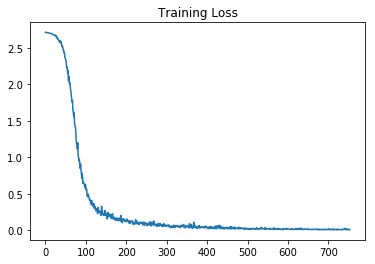

In [10]:
%matplotlib inline
plt.plot(loss_array)
plt.title("Training Loss")
plt.show()

# Model Testing

Once the model is trained, Lets test it on test dataset.

    1. Testing on some example

In [11]:
## dataloader for test dataset 
dataiter = iter(test_loader)
data, labels = dataiter.next()
data, target = Variable(data), Variable(target)

output = model(data)
_, preds_tensor = torch.max(output, 1)
preds_tensor=preds_tensor.cpu()
preds = np.squeeze(preds_tensor.numpy())
print ("Actual:   ", np.array(labels[:10]))
print ("Predicted:", preds[:10])

Actual:    [ 3 12  5  9 14 12 12  5  3 10]
Predicted: [ 3 12  5  9 14 12 12  5  3 10]


    2. Checking Accuracy of Model

In [12]:
# run a test loop
test_loss = 0
correct = 0
for data, target in test_loader:
    data, target = Variable(data), Variable(target)
    
    model_out = model(data)
    # sum up batch loss
    
    test_loss += criterion(model_out, target).item()
    pred = model_out.data.max(1)[1]  # get the index of the max log-probability
    correct += pred.eq(target.data).sum()

test_loss /= len(test_loader.dataset)

print('Average loss: ',test_loss)
print('Accuracy: ',np.array(100. * correct / len(test_sampler)),'%')
print ('Total Test Examples: ',len(test_sampler))
print ('Correct predicted Examples: ',int(correct))


Average loss:  5.501896880061345e-06
Accuracy:  100 %
Total Test Examples:  1630
Correct predicted Examples:  1630
